# Определение перспективного тарифа для компании "Мегалайн"

Заказчик - компания "Мегалайн" - поручила сделать предварительный анализ своих тарифов на небольшой выборке клиентов, около 500 пользователей. Предоставленные данные содержат основные данные о клиентах, в том числе их возраст, город проживания, подключенный тариф, количество совершённых звонков и отправленных сообщений за 2018 год. Задача состоит в том, чтобы проанализировать поведение клиентов и определить наиболее выгодный для компании тариф.

## Предобработка данных

In [1]:
import pandas as pd


calls = pd.read_csv('/datasets/calls.csv')
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


In [2]:
internet = pd.read_csv('/datasets/internet.csv')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.6+ MB


В таблице со звонками сомнения вызвал столбец с указанием даты звонка (*call_date*). Тип данных в нём был заменён на datetime. То же самое было сделано в таблице с данными о пользовании Интернетом в столбце *session_date*.

In [3]:
messages = pd.read_csv('/datasets/messages.csv')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null datetime64[ns]
user_id         123036 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


In [4]:
tariffs = pd.read_csv('/datasets/tariffs.csv')
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mg_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [5]:
users = pd.read_csv('/datasets/users.csv')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 31.4+ KB


In [6]:
null_calls = calls[calls['duration'] == 0.0]['duration'].count()
print('В таблице "Звонки" {} записей с продолжительностью звонков 0.0'.format(null_calls))

#удаление строк с длительностью звонка 0.0
calls = calls.query('duration != 0.0')

В таблице "Звонки" 39613 записей с продолжительностью звонков 0.0


Скорее всего звонки длительностью 0 минут 0 секунд - это либо ошибка системы, либо попытка дозвониться до абонента, который не отвечает. И в том, и в другом случае эти данные нам ничего не дадут при проведении анализа. В связи с этим, они были удалены из набора данных.

## Помесячная выручка с каждого пользователя

In [7]:
calls['month'] = pd.DatetimeIndex(calls['call_date']).month
messages['month'] = pd.DatetimeIndex(messages['message_date']).month
internet['month'] = pd.DatetimeIndex(internet['session_date']).month

In [8]:
#(вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика;
#остаток умножьте на значение из тарифного плана;
#прибавьте абонентскую плату, соответствующую тарифному плану).
import numpy as np


def include_tariff(dataframe):
    dataframe = pd.merge(dataframe, users, on='user_id')
    list_of_columns = ['age', 'city', 'first_name', 'last_name', 'reg_date', 'churn_date']
    for item in list_of_columns:
        dataframe.__delitem__(item)
    return dataframe

def eliminate_negative_values(data_column):
    for val in data_column:
        if val < 0:
            data_column = data_column.replace(val, 0)
    return data_column


calls = include_tariff(calls)

messages = include_tariff(messages)

internet = include_tariff(internet)

In [9]:
#таблица "Звонки", сгруппированная по клиентам и месяцам
calls_smart_users = calls[calls['tariff'] == 'smart']
calls_ultra_users = calls[calls['tariff'] == 'ultra']

calls_smart_by_user_and_month = calls_smart_users.groupby(['user_id', 'month']).sum()
calls_ultra_by_user_and_month = calls_ultra_users.groupby(['user_id', 'month']).sum()

calls_smart_by_user_and_month['duration'] = np.ceil(calls_smart_by_user_and_month['duration']).astype('int')
calls_ultra_by_user_and_month['duration'] = np.ceil(calls_ultra_by_user_and_month['duration']).astype('int')

#суммарное количества минут минус бесплатный лимит для каждого тарифа
calls_smart_by_user_and_month['extra_mins'] = np.ceil(calls_smart_by_user_and_month['duration'] - 500).astype('int')
calls_ultra_by_user_and_month['extra_mins'] = np.ceil(calls_ultra_by_user_and_month['duration'] - 3000).astype('int')

#замена отрицательных значений на нулевые
calls_smart_by_user_and_month['extra_mins'] = eliminate_negative_values(calls_smart_by_user_and_month['extra_mins'])
calls_ultra_by_user_and_month['extra_mins'] = eliminate_negative_values(calls_ultra_by_user_and_month['extra_mins'])

#плата за дополнительные минуты тарифа "Смарт"
calls_smart_by_user_and_month['extra_mins_paid'] = calls_smart_by_user_and_month['extra_mins'] * 3

print('Тариф "Ультра"')
calls_ultra_by_user_and_month.tail(12)

Тариф "Ультра"


duration  extra_mins
user_id month                      
1491    8           581           0
        9           503           0
        10          544           0
        11          488           0
        12          635           0
1493    11          163           0
        12          539           0
1495    8            88           0
        9           767           0
        10          972           0
        11          893           0
        12          971           0

In [10]:
print('Тариф "Смарт"')
calls_smart_by_user_and_month.tail(12)

Тариф "Смарт"


duration  extra_mins  extra_mins_paid
user_id month                                       
1496    12          484           0                0
1497    10          464           0                0
        11          347           0                0
        12          516          16               48
1498    7           167           0                0
        8           377           0                0
        9           447           0                0
        10          233           0                0
1499    9            65           0                0
        10          430           0                0
        11          577          77              231
        12          466           0                0

In [11]:
sms_smart_users = messages[messages['tariff'] == 'smart']
sms_ultra_users = messages[messages['tariff'] == 'ultra']

sms_smart_by_user_and_month = sms_smart_users.groupby(['user_id', 'month']).count()
sms_smart_by_user_and_month.__delitem__('tariff')
sms_smart_by_user_and_month.__delitem__('message_date')
sms_smart_by_user_and_month.columns = ['sms']

sms_ultra_by_user_and_month = sms_ultra_users.groupby(['user_id', 'month']).count()
sms_ultra_by_user_and_month.__delitem__('tariff')
sms_ultra_by_user_and_month.__delitem__('message_date')
sms_ultra_by_user_and_month.columns = ['sms']

sms_smart_by_user_and_month['extra_sms'] = sms_smart_by_user_and_month['sms'] - 50
sms_ultra_by_user_and_month['extra_sms'] = sms_ultra_by_user_and_month['sms'] - 1000

sms_smart_by_user_and_month['extra_sms'] = eliminate_negative_values(sms_smart_by_user_and_month['extra_sms'])
sms_ultra_by_user_and_month['extra_sms'] = eliminate_negative_values(sms_ultra_by_user_and_month['extra_sms'])
        
sms_smart_by_user_and_month['extra_sms_paid'] = sms_smart_by_user_and_month['extra_sms'] * 3

sms_smart_by_user_and_month.tail(10)

sms  extra_sms  extra_sms_paid
user_id month                                
1497    11      14          0               0
        12      17          0               0
1498    7       20          0               0
        8       62         12              36
        9       44          0               0
        10      42          0               0
1499    9       11          0               0
        10      48          0               0
        11      59          9              27
        12      66         16              48

In [12]:
internet_smart_users = internet[internet['tariff'] == 'smart']
internet_ultra_users = internet[internet['tariff'] == 'ultra']

internet_smart_by_user_and_month = internet_smart_users.groupby(['user_id', 'month']).sum()
internet_ultra_by_user_and_month = internet_ultra_users.groupby(['user_id', 'month']).sum()

internet_smart_by_user_and_month['mb_used'] = np.ceil(internet_smart_by_user_and_month['mb_used']).astype('int')
internet_ultra_by_user_and_month['mb_used'] = np.ceil(internet_ultra_by_user_and_month['mb_used']).astype('int')

internet_smart_by_user_and_month['extra_gb'] = np.ceil((internet_smart_by_user_and_month['mb_used'] / 1024) - 15).astype('int')
internet_ultra_by_user_and_month['extra_gb'] = np.ceil((internet_ultra_by_user_and_month['mb_used'] / 1024) - 30).astype('int')

internet_smart_by_user_and_month['extra_gb'] = eliminate_negative_values(internet_smart_by_user_and_month['extra_gb'])
internet_ultra_by_user_and_month['extra_gb'] = eliminate_negative_values(internet_ultra_by_user_and_month['extra_gb'])

internet_smart_by_user_and_month['extra_gb_paid'] = internet_smart_by_user_and_month['extra_gb'] * 200
internet_ultra_by_user_and_month['extra_gb_paid'] = internet_ultra_by_user_and_month['extra_gb'] * 150

internet_ultra_by_user_and_month.tail(12)

mb_used  extra_gb  extra_gb_paid
user_id month                                  
1491    8        17280         0              0
        9        15119         0              0
        10       24366         0              0
        11       17829         0              0
        12       22062         0              0
1493    11       11685         0              0
        12       42736        12           1800
1495    8         2615         0              0
        9        33068         3            450
        10       29364         0              0
        11       38940         9           1350
        12       23427         0              0

In [13]:
#dataframes = [messages, calls, internet]
smart_messages_and_calls = pd.merge(sms_smart_by_user_and_month, calls_smart_by_user_and_month, on=['user_id', 'month'])
smart_total_info = pd.merge(internet_smart_by_user_and_month, smart_messages_and_calls, on=['user_id', 'month'])

ultra_messages_and_calls = pd.merge(sms_ultra_by_user_and_month, calls_ultra_by_user_and_month, on=['user_id', 'month'])
ultra_total_info = pd.merge(internet_ultra_by_user_and_month, ultra_messages_and_calls, on=['user_id', 'month'])

#добавим в таблицу столбец с 
smart_total_info['total_payment'] = (
    smart_total_info['extra_gb_paid'] + smart_total_info['extra_sms_paid'] + smart_total_info['extra_mins_paid'] + 550
)

ultra_total_info['total_payment'] = (
    ultra_total_info['extra_gb_paid'] + ultra_total_info['extra_sms'] + ultra_total_info['extra_mins'] + 1950
)

print('Сводная таблица для тарифа "Смарт"')
smart_total_info

Сводная таблица для тарифа "Смарт"


mb_used  extra_gb  extra_gb_paid  sms  extra_sms  \
user_id month                                                     
1002    6        10857         0              0    4          0   
        7        17581         3            600   11          0   
        8        20320         5           1000   13          0   
        9        16692         2            400    4          0   
        10       13889         0              0   10          0   
...                ...       ...            ...  ...        ...   
1498    10       20580         6           1200   42          0   
1499    9         1846         0              0   11          0   
        10       17789         3            600   48          0   
        11       17964         3            600   59          9   
        12       13056         0              0   66         16   

               extra_sms_paid  duration  extra_mins  extra_mins_paid  \
user_id month                                                          
1002    6                   0       111           0                0   
        7                   0       205           0                0   
        8                   0       270           0                0   
        9                   0       196           0                0   
        10                  0       200           0                0   
...                       ...       ...         ...              ...   
1498    10                  0       233           0                0   
1499    9                   0        65           0                0   
        10                  0       430           0                0   
        11                 27       577          77              231   
        12                 48       466           0                0   

               total_payment  
user_id month                 
1002    6                550  
        7               1150  
        8               1550  
        9                950  
        10               550  
...                      ...  
1498    10              1750  
1499    9                550  
        10              1150  
        11              1408  
        12               598  

[1913 rows x 10 columns]

In [14]:
print('Сводная таблица для тарифа "Ультра"')
ultra_total_info

Сводная таблица для тарифа "Ультра"


mb_used  extra_gb  extra_gb_paid  sms  extra_sms  duration  \
user_id month                                                               
1000    5         2254         0              0   22          0       151   
        6        23234         0              0   60          0       159   
        7        14004         0              0   75          0       319   
        8        14056         0              0   81          0       390   
        9        14569         0              0   57          0       441   
...                ...       ...            ...  ...        ...       ...   
1495    8         2615         0              0   13          0        88   
        9        33068         3            450   82          0       767   
        10       29364         0              0   82          0       972   
        11       38940         9           1350   79          0       893   
        12       23427         0              0   84          0       971   

               extra_mins  total_payment  
user_id month                             
1000    5               0           1950  
        6               0           1950  
        7               0           1950  
        8               0           1950  
        9               0           1950  
...                   ...            ...  
1495    8               0           1950  
        9               0           2400  
        10              0           1950  
        11              0           3300  
        12              0           1950  

[749 rows x 8 columns]

Просмотр расположенных выше таблиц наталкивает на промежуточные выводы. Пользователи тарифа "Ультра" редко доплачивают за услуги сверх своего тарифа. Пользователи тарифа "Смарт" чаще покупают дополнительные услуги, но редко их общая месячная плата  превышает плату за тариф пользователей "Ультра" (1950 рублей). Эти выводы предварительные, далее будет проведён дополнительный анализ, на основе которого можно будет строить более точные суждения.

## Средние значения, дисперсия и стандартное отклонение

In [15]:
#Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?
print('В месяц пользователи тарифа "Смарт" в среднем:')
print('посылают {:.0f} сообщений,'.format(smart_total_info['sms'].mean()))
print('говорят {:.0f} минут,'.format(smart_total_info['duration'].mean()))
print('тратят {:.0f} Мб трафика.'.format(smart_total_info['mb_used'].mean()))
print()
print('В месяц пользователи тарифа "Ультра" в среднем:')
print('посылают {:.0f} сообщение,'.format(ultra_total_info['sms'].mean()))
print('говорят {:.0f} минут,'.format(ultra_total_info['duration'].mean()))
print('тратят {:.0f} Мб трафика.'.format(ultra_total_info['mb_used'].mean()))

В месяц пользователи тарифа "Смарт" в среднем:
посылают 39 сообщений,
говорят 398 минут,
тратят 16247 Мб трафика.

В месяц пользователи тарифа "Ультра" в среднем:
посылают 61 сообщение,
говорят 528 минут,
тратят 19584 Мб трафика.


In [16]:
#Посчитайте среднее количество, дисперсию и стандартное отклонение. 
smart_sms_variance = np.var(smart_total_info['sms'], ddof=1)
smart_mins_variance = np.var(smart_total_info['duration'], ddof=1)
smart_internet_variance = np.var(smart_total_info['mb_used'], ddof=1)
smart_dictionary = {'sms': [smart_sms_variance], 'minutes': [smart_mins_variance], 'mb': [smart_internet_variance]} 
smart_variance_table = pd.DataFrame(data=smart_dictionary)
print('Дисперсия для тарифа "Смарт"')
print(smart_variance_table)
print()
ultra_sms_variance = np.var(ultra_total_info['sms'], ddof=1)
ultra_mins_variance = np.var(ultra_total_info['duration'], ddof=1)
ultra_internet_variance = np.var(ultra_total_info['mb_used'], ddof=1)
ultra_dictionary = {'sms': [ultra_sms_variance], 'minutes': [ultra_mins_variance], 'mb': [ultra_internet_variance]} 
ultra_variance_table = pd.DataFrame(data=ultra_dictionary)
print('Дисперсия для тарифа "Ультра"')
print(ultra_variance_table)


Дисперсия для тарифа "Смарт"
          sms       minutes            mb
0  719.450287  31397.088474  3.355902e+07

Дисперсия для тарифа "Ультра"
           sms      minutes            mb
0  1983.645295  85929.08101  9.304037e+07


In [17]:
smart_sms_st_dev = np.std(smart_total_info['sms'], ddof=1)
smart_mins_st_dev = np.std(smart_total_info['duration'], ddof=1)
smart_internet_st_dev = np.std(smart_total_info['mb_used'], ddof=1)
smart_dict = {'sms': [smart_sms_st_dev], 'minutes': [smart_mins_st_dev], 'mb': [smart_internet_st_dev]} 
smart_st_dev_table = pd.DataFrame(data=smart_dict)
print('Стандартное отклонение для тарифа "Смарт"')
print(smart_st_dev_table)
print()
ultra_sms_st_dev = np.std(ultra_total_info['sms'], ddof=1)
ultra_mins_st_dev = np.std(ultra_total_info['duration'], ddof=1)
ultra_internet_st_dev = np.std(ultra_total_info['mb_used'], ddof=1)
ultra_dict = {'sms': [ultra_sms_st_dev], 'minutes': [ultra_mins_st_dev], 'mb': [ultra_internet_st_dev]} 
ultra_st_dev_table = pd.DataFrame(data=ultra_dict)
print('Стандартное отклонение для тарифа "Ультра"')
print(ultra_st_dev_table)

Стандартное отклонение для тарифа "Смарт"
        sms     minutes           mb
0  26.82257  177.192236  5793.014623

Стандартное отклонение для тарифа "Ультра"
         sms     minutes           mb
0  44.538133  293.136625  9645.743518


In [18]:
smart_mean = smart_total_info.pivot_table(index='month', values=['sms', 'duration', 'mb_used'], aggfunc='mean').reset_index()
smart_mean['sms'] = smart_mean['sms'].astype('int')
smart_mean['duration'] = smart_mean['duration'].astype('int')
smart_mean['gb_used'] = (smart_mean['mb_used'] / 1024).astype('int')
smart_mean

,month,duration,mb_used,sms,gb_used
0,1,206,8670.733333,19,8
1,2,295,11940.140000,27,11
2,3,371,14640.826087,35,14
3,4,364,13587.105263,35,13
4,5,377,16155.024590,39,15
5,6,377,15796.042553,38,15
6,7,386,15823.643678,38,15
7,8,405,16847.495050,39,16
8,9,405,16373.504505,39,15
9,10,403,16773.691700,39,16


In [19]:
ultra_mean = ultra_total_info.pivot_table(index='month', values=['sms', 'duration', 'mb_used'], aggfunc='mean').reset_index()
ultra_mean['sms'] = ultra_mean['sms'].astype('int')
ultra_mean['duration'] = ultra_mean['duration'].astype('int')
ultra_mean['gb_used'] = (ultra_mean['mb_used'] / 1024).astype('int')
ultra_mean

,month,duration,mb_used,sms,gb_used
0,1,450,13989.857143,43,13
1,2,378,14893.000000,37,14
2,3,522,17129.920000,47,16
3,4,471,16822.315789,45,16
4,5,503,18935.375000,50,18
5,6,470,18483.761905,50,18
6,7,535,20163.808824,60,19
7,8,504,19316.500000,57,18
8,9,539,19353.438202,62,18
9,10,545,20500.381443,70,20


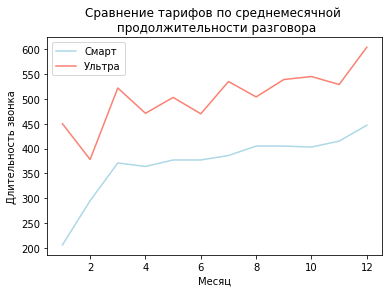

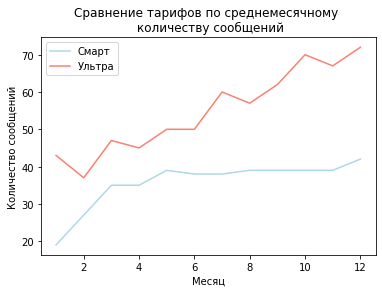

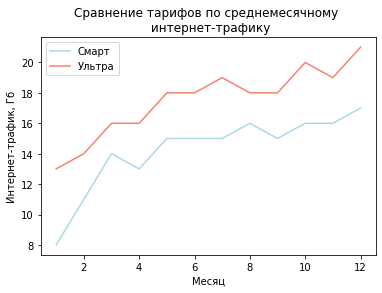

In [21]:
import matplotlib.pyplot as plt



def print_monthly_plot(smart_values_for_y, ultra_values_for_y, plot_title, plot_y_label, plot_x_label):
    
    month = [1,2,3,4,5,6,7,8,9,10,11,12]
    
    fig, ax = plt.subplots(sharey=True)
    ax.plot(month, smart_values_for_y, color='lightblue', label='Смарт')
    ax.plot(month, ultra_values_for_y, color='salmon', label='Ультра')
    ax.set(title=plot_title, ylabel=plot_y_label, xlabel=plot_x_label)
    ax.margins(0.05)
    ax.legend(loc = 'best')

print_monthly_plot(smart_mean['duration'], ultra_mean['duration'], 'Сравнение тарифов по среднемесячной \n продолжительности разговора',
'Длительность звонка', 'Месяц')
print_monthly_plot(smart_mean['sms'], ultra_mean['sms'], 'Сравнение тарифов по среднемесячному \n количеству сообщений',
'Количество сообщений', 'Месяц')
print_monthly_plot(smart_mean['gb_used'], ultra_mean['gb_used'], 'Сравнение тарифов по среднемесячному \n интернет-трафику',
'Интернет-трафик, Гб', 'Месяц')

На основе построенных графиков можно сделать следующие выводы:
1. Пользователи тарифа "Ультра" используют сообщений, минут и трафика больше, чем пользователи тарифа "Смарт", но и пакет включённых услуг у них больше.
2. Пользователи тарифа "Ультра" редко доплачивают за услуги сверх установленных. На графиках чётко видно, что даже в самой высокой точке объём используемых услуг не превышает 3000 минут разговора, 1000 сообщений и 30 Гб интернета соответственно.
3. Пользователи тарифа "Смарт" укладываются в рамки предложенных услуг по сообщениям и минутам. Однако за интернет им приходится часто переплачивать.

### Проверка гипотез

**Гипотеза № 1**<br>
Нулевая: Cредняя выручка пользователей тарифов «Ультра» и «Смарт» одинакова.

In [21]:
from scipy import stats as st


alpha = 0.05

results = st.ttest_ind(
    smart_total_info['total_payment'], 
    ultra_total_info['total_payment'])

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем гипотезу")
else:
    print("Не получилось отвергнуть гипотезу")

p-значение: 3.2742925486884215e-133
Не получилось отвергнуть гипотезу


**Гипотеза №2** Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

In [22]:
moscow_users = users.query('city == "Москва"')['user_id']
moscow_payment = pd.concat([smart_total_info.query('user_id.isin(@moscow_users)')['total_payment'],
                           ultra_total_info.query('user_id.isin(@moscow_users)')['total_payment']]
)
other_payment = pd.concat([smart_total_info.query('user_id not in @moscow_users')['total_payment'],
                           ultra_total_info.query('user_id not in @moscow_users')['total_payment']]
)

city_results = st.ttest_ind(
    moscow_payment, 
    other_payment)

print('p-значение:', city_results.pvalue)

if (city_results.pvalue > alpha):
    print("Отвергаем гипотезу")
else:
    print("Не получилось отвергнуть гипотезу")

p-значение: 0.08140368129392532
Отвергаем гипотезу


В обоих случаях мы используем альтернативную гипотезу, так как ищем разницу между средним двух наборов данных. Для их проверки было использовано р-значение и критический уровень статистической значимости (*alpha*). Если р-значение было больше *alpha*, гипотеза отвергалась, так как в таком случае средние значения двух наборов данных будут примерно равны, а нам необходимо оценить гипотезу об их различии.

Таким образом, было выявлено следующее:
1. Cредняя выручка пользователей тарифов «Ультра» и «Смарт» действительно различается
2. Cредняя выручка пользователей из Москвы **не** отличается от выручки пользователей из других регионов

In [23]:
smart_revenue = smart_total_info['total_payment'].sum()
ultra_revenue = ultra_total_info['total_payment'].sum()
print('Доходы от тарифа "Смарт" : {} рублей'.format(smart_revenue))
print('Доходы от тарифа "Ультра" : {} рублей'.format(ultra_revenue))

Доходы от тарифа "Смарт" : 2406869 рублей
Доходы от тарифа "Ультра" : 1534950 рублей


## Общий вывод

Предварительный анализ тарифов на небольшой выборке клиентов показал, что наиболее прибыльным является тариф "Ультра".